# **Comparación de clasificadores de Machine Learning en la elección del método de transporte**

## 1. Importo librerías

In [ ]:
# Importo las librerías necesarias antes de comenzar
import pandas as pd
import numpy as np

# Librerías para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para modelos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score

# Librerías para las pruebas estadísticas
from scipy.stats import kruskal
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

# Librerías para exportar e importar datos
from google.colab import drive
from google.colab import files

## 2. Exploración de datos

In [ ]:
# Leo mi dataset
drive.mount('/content/drive')
colab_csv_path = 'Data/nts_data.csv'
nts = pd.read_csv(colab_csv_path)
nts.head()

Mounted at /content/drive


,mode_main,distance,density,age,male,ethnicity,education,income,cars,license,bicycles,weekend,diversity,green,temp,precip,wind
0,walk,1.0,1.26259,84,no,native,lower,less20,0,yes,1,yes,1.24604,26.881233,0.1,0.10,3.0
1,walk,10.0,1.26259,84,no,native,lower,less20,0,yes,1,yes,1.24604,26.881233,0.1,0.10,3.0
2,car,3.0,1.76264,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8
3,car,3.0,1.76264,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8
4,car,61.5,1.76264,27,yes,western,middle,20to40,1,yes,2,yes,1.53959,36.045955,-3.4,0.05,1.8


A priori parecen datos muy limpios, pero seguiré explorando

In [ ]:
# Reviso que tipo de variables tengo
nts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230608 entries, 0 to 230607
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   mode_main  230608 non-null  object 
 1   distance   230608 non-null  float64
 2   density    230608 non-null  float64
 3   age        230608 non-null  int64  
 4   male       230608 non-null  object 
 5   ethnicity  230608 non-null  object 
 6   education  230608 non-null  object 
 7   income     230608 non-null  object 
 8   cars       230608 non-null  int64  
 9   license    230608 non-null  object 
 10  bicycles   230608 non-null  int64  
 11  weekend    230608 non-null  object 
 12  diversity  230608 non-null  float64
 13  green      230608 non-null  float64
 14  temp       230608 non-null  float64
 15  precip     230608 non-null  float64
 16  wind       230608 non-null  float64
dtypes: float64(7), int64(3), object(7)
memory usage: 29.9+ MB


In [ ]:
# Reviso si hay nulos
nts.isnull().sum()

mode_main    0
distance     0
density      0
age          0
male         0
ethnicity    0
education    0
income       0
cars         0
license      0
bicycles     0
weekend      0
diversity    0
green        0
temp         0
precip       0
wind         0
dtype: int64

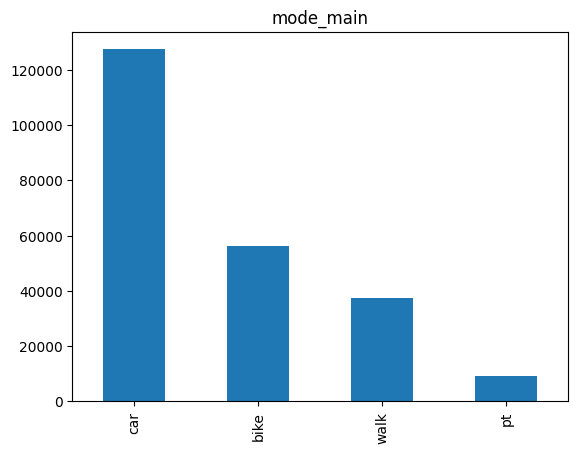

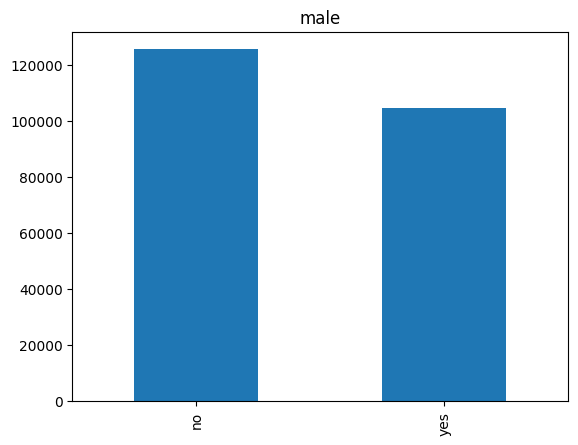

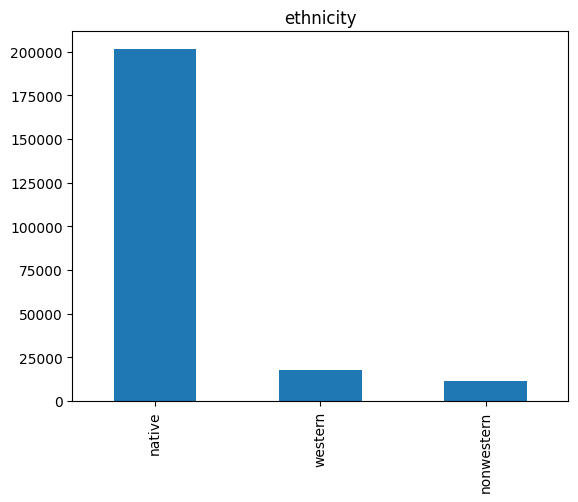

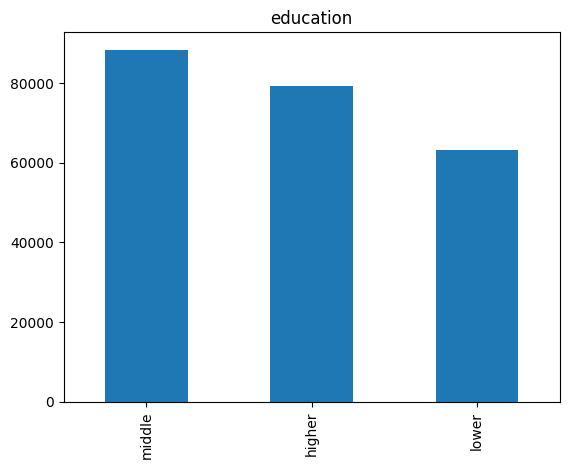

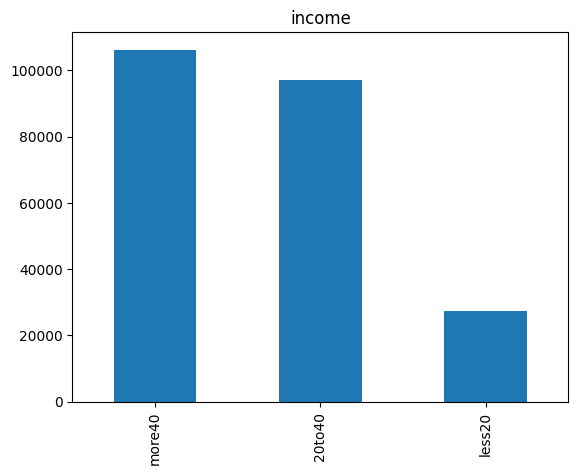

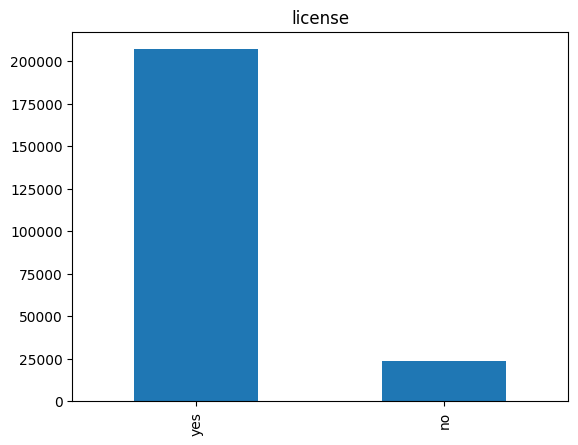

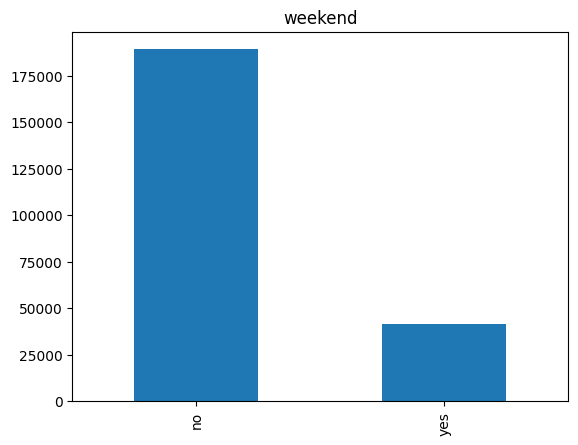

In [ ]:
# Voy a visualizar las variables categóricas por si hubiera que introducir algún cambio o alguna no estuviera correcta

object_col = nts.select_dtypes(include='object').columns

for var in object_col:
    counts = nts[var].value_counts()
    plt.figure()
    counts.plot(kind='bar')
    plt.title(var)

plt.show()


Los datos están limpios y no continen ningún null, por lo que no proseguiré con la exploración.

## 3. Preprocesamiento del modelo

### 3.1. Transformación de variables categóricas a numéricas

Para poder realizar los modelos, debo primero transformar las variables categóricas a numéricas, al no ser muchas lo haré manualmente, para asegurarme de que están correctamente transformadas.

In [ ]:
# Realizo la transfornación de variables
nts.mode_main.replace(('walk', 'car', 'pt', 'bike'),
                      (1,2,3,4),inplace=True)
nts.male.replace(('no', 'yes'),
                 (1,2),inplace=True)
nts.ethnicity.replace(('native', 'western', 'nonwestern'),
                      (1,2,3),inplace=True)
nts.education.replace(('lower', 'middle', 'higher'),
                      (1,2,3),inplace=True)
nts.income.replace(('less20', '20to40', 'more40'),
                   (1,2,3),inplace=True)
nts.license.replace(('yes', 'no'),
                    (1,2),inplace=True)
nts.weekend.replace(('yes', 'no'),
                    (1,2),inplace=True)

nts.head()

,mode_main,distance,density,age,male,ethnicity,education,income,cars,license,bicycles,weekend,diversity,green,temp,precip,wind
0,1,1.0,1.26259,84,1,1,1,1,0,1,1,1,1.24604,26.881233,0.1,0.10,3.0
1,1,10.0,1.26259,84,1,1,1,1,0,1,1,1,1.24604,26.881233,0.1,0.10,3.0
2,2,3.0,1.76264,27,2,2,2,2,1,1,2,1,1.53959,36.045955,-3.4,0.05,1.8
3,2,3.0,1.76264,27,2,2,2,2,1,1,2,1,1.53959,36.045955,-3.4,0.05,1.8
4,2,61.5,1.76264,27,2,2,2,2,1,1,2,1,1.53959,36.045955,-3.4,0.05,1.8


In [ ]:
# Compruebo que todas sean numéricas
nts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230608 entries, 0 to 230607
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   mode_main  230608 non-null  int64  
 1   distance   230608 non-null  float64
 2   density    230608 non-null  float64
 3   age        230608 non-null  int64  
 4   male       230608 non-null  int64  
 5   ethnicity  230608 non-null  int64  
 6   education  230608 non-null  int64  
 7   income     230608 non-null  int64  
 8   cars       230608 non-null  int64  
 9   license    230608 non-null  int64  
 10  bicycles   230608 non-null  int64  
 11  weekend    230608 non-null  int64  
 12  diversity  230608 non-null  float64
 13  green      230608 non-null  float64
 14  temp       230608 non-null  float64
 15  precip     230608 non-null  float64
 16  wind       230608 non-null  float64
dtypes: float64(7), int64(10)
memory usage: 29.9 MB


### 3.2. Partición training - test

En primer lugar haré una partición training-test para poder después entrenar y testear mis modelos.

In [ ]:
# Hago mi partición training - test
X_train, X_test, y_train, y_test = train_test_split (nts.drop('mode_main', axis=1),
                                                     nts.mode_main,
                                                     test_size = 0.2,
                                                     random_state = 0,
                                                     stratify = nts.mode_main)

In [ ]:
# Como la variable temperatura presenta valores negativos voy a revisarlo antes de comenzar a modelar
print(np.any(X_train < 0))
print(np.min(X_train))

True
distance      0.10000
density       0.00184
age          18.00000
male          1.00000
ethnicity     1.00000
education     1.00000
income        1.00000
cars          0.00000
license       1.00000
bicycles      0.00000
weekend       1.00000
diversity     0.00000
green         0.00000
temp         -9.00000
precip        0.00000
wind          0.40000
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
# Realizo el escalado de características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Convierto X_train y y_train en arrays NumPy para después no tener problemas a la hora de modelar
X_train = np.array(X_train)
y_train = np.array(y_train)

## 4. Modelo analítico de clasificación

El estudio utiliza una técnica llamada "10-fold cross-validation" (validación cruzada de 10 pliegues) para evaluar el rendimiento de los clasificadores. Esto implica dividir los datos en 10 conjuntos disjuntos. En cada iteración, un conjunto se utiliza como datos de prueba y los otros nueve se utilizan para entrenar el modelo. Esto reduce el sesgo en la estimación del rendimiento del modelo.

### 4.1. Multinomial Logit Model

En este estudio, el modelo MNL se estima utilizando un enfoque basado en una red neuronal artificial (RNA). La RNA utilizada no tiene capas ocultas y se entrena mediante propagación hacia atrás con una constante de decaimiento de peso de 0.01.

In [ ]:
# Defino el modelo
ml_model = MLPClassifier(hidden_layer_sizes=(), alpha=0.01, max_iter=1000)

# Defino el diccionario para almacenar métricas
ml_metrics = {'accuracy': [], 'sensitivity': []}

# Realizo la Validación cruzada y divido los datos en conjuntos de entrenamiento y prueba para esta iteración
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

  # Entreno el modelo en el conjunto de entrenamiento actual
    ml_model.fit(X_train_fold, y_train_fold)
    ml_y_pred = ml_model.predict(X_test_fold)

  # Calculo las métricas de desempeño
    ml_accuracy = accuracy_score(y_test_fold, ml_y_pred)
    ml_sensitivity = balanced_accuracy_score(y_test_fold, ml_y_pred)

  # Almaceno las métricas de esta iteración en el diccionario
    ml_metrics['accuracy'].append(ml_accuracy)
    ml_metrics['sensitivity'].append(ml_sensitivity)

# Imprimo los resultados del Modelo Multinomial Logit (RNA)
print("Resultados del Modelo Multinomial Logit (RNA):")
print(f"Accuracy: {np.mean(ml_metrics['accuracy'])}")
print(f"Average Sensitivity: {np.mean(ml_metrics['sensitivity'])}")

Resultados del Modelo Multinomial Logit (RNA):
Accuracy: 0.6570092406708313
Average Sensitivity: 0.45609398268297535


El modelo Multinomial Logit tiene una precisión del 65.7%, lo que significa que es capaz de predecir correctamente la mayoría de los casos. Sin embargo, su sensibilidad promedio es del 45.6%, lo que sugiere que tiene ciertas dificultades para detectar correctamente todos los casos positivos.

A continuación analizaré la importancia de mis variables dentro de mi modelo

In [ ]:
column_names = ["distance", "density", "age", "male", "ethnicity", "education",
                "income", "cars", "license", "bicycles", "weekend",
                "diversity", "green", "temp", "precip", "wind"]

In [ ]:
# Creo un diccionario de importancias
imp = {}
for i, col_name in enumerate(column_names):
    imp[col_name] = [ml_model.coefs_[0][i].mean()]

# Creo un DataFrame a partir del diccionario 'imp'
ml_importance_df = pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"])
ml_importance_df = ml_importance_df.sort_values("Importance", ascending=False)

# Aplico estilo de background_gradient para resaltar la importancia
ml_styled_importance = ml_importance_df.style.background_gradient()

# Imprimo el DataFrame con el nombre de las variables originales y la importancia resaltada
print("Importancias de las variables:")
display(ml_styled_importance)

Importancias de las variables:


,Importance
license,0.296543
precip,0.121974
bicycles,0.102869
cars,0.098906
wind,0.089439
density,0.084009
education,0.060711
age,0.015418
green,0.000729
temp,-0.047501


### 4.2. Naive Bayes

En este estudio, el modelo Naive Bayes se basa en la estimación de densidad de núcleo con un factor de corrección de Laplace de 0.001. Este enfoque permite modelar las distribuciones de probabilidad de las características en cada clase utilizando una función de densidad de núcleo. La corrección de Laplace se aplica para evitar problemas de probabilidades nulas en el cálculo.

In [ ]:
# Defino el modelo Naive Bayes con estimación de densidad de núcleo y Laplace
nb_model = GaussianNB(var_smoothing=0.001)

# Defino el diccionario para almacenar métricas
nb_metrics = {'accuracy': [], 'sensitivity': []}

# Realizo la Validación cruzada y divido los datos en conjuntos de entrenamiento y prueba para esta iteración
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

  # Entreno el modelo en el conjunto de entrenamiento actual
    nb_model.fit(X_train_fold, y_train_fold)
    nb_y_pred = nb_model.predict(X_test_fold)

  # Calculo las métricas de desempeño
    nb_accuracy = accuracy_score(y_test_fold, nb_y_pred)
    nb_sensitivity = balanced_accuracy_score(y_test_fold, nb_y_pred)

  # Almaceno las métricas de esta iteración en el diccionario
    nb_metrics['accuracy'].append(nb_accuracy)
    nb_metrics['sensitivity'].append(nb_sensitivity)

# Imprimo los resultados del Modelo Naive Bayes
print("Resultados del Modelo Naive Bayes:")
print(f"Accuracy: {np.mean(nb_metrics['accuracy'])}")
print(f"Sensitivity: {np.mean(nb_metrics['sensitivity'])}")

Resultados del Modelo Naive Bayes:
Accuracy: 0.5555652332886276
Sensitivity: 0.45912040852704517


El modelo Naive Bayes tiene una precisión ligeramente inferior del 55.6%, lo que indica que sus predicciones correctas son menos frecuentes en comparación con el modelo anterior. Además, su sensibilidad del 45.9% sugiere que el modelo Naive Bayes también tiene dificultades para detectar correctamente todos los casos positivos, aunque en este caso la sensibilidad es similar a la del modelo anterior.

Los modelos Naive Bayes no tienen importancia de características como lo tienen otros modelos. Esto se debe a que los modelos Naive Bayes se basan en probabilidades y asumen independencia condicional entre las características dadas las clases.

### 4.3. Bagging


En este estudio, se ensamblan 350 árboles de clasificación. Cada árbol se construye sin poda hasta que la asignación de clase en cada nodo sea inequívoca.

In [ ]:
# Defino el modelo Bagging con Árboles de Clasificación
base_classifier = DecisionTreeClassifier()
bagging_model = BaggingClassifier(base_classifier, n_estimators=350, bootstrap=False)

# Defino el diccionario para almacenar métricas
bagging_metrics = {'accuracy': [], 'sensitivity': []}

# Realizo la Validación cruzada y divido los datos en conjuntos de entrenamiento y prueba para esta iteración
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

  # Entreno el modelo en el conjunto de entrenamiento actual
    bagging_model.fit(X_train_fold, y_train_fold)
    bagging_y_pred = bagging_model.predict(X_test_fold)

  # Calculo las métricas de desempeño
    bagging_accuracy = accuracy_score(y_test_fold, bagging_y_pred)
    bagging_sensitivity = balanced_accuracy_score(y_test_fold, bagging_y_pred)

  # Almaceno las métricas de esta iteración en el diccionario
    bagging_metrics['accuracy'].append(bagging_accuracy)
    bagging_metrics['sensitivity'].append(bagging_sensitivity)

# Imprimo los resultados del Modelo Bagging
print("Resultados del Modelo Bagging:")
print(f"Accuracy: {np.mean(bagging_metrics['accuracy'])}")
print(f"Sensitivity: {np.mean(bagging_metrics['sensitivity'])}")

Resultados del Modelo Bagging:
Accuracy: 0.7519974176249313
Sensitivity: 0.6641918552484328


Comparado con los modelos anteriores, el modelo Bagging muestra un rendimiento significativamente mejor en términos de precisión y sensibilidad. Su precisión del 75.2% indica que es capaz de predecir correctamente una gran proporción de los casos en comparación con los modelos anteriores. Además, su sensibilidad del 66.4% sugiere que tiene una sólida capacidad para detectar casos positivos en comparación con los modelos anteriores.

A continuación analizaré la importancia de mis variables dentro de mi modelo

In [ ]:
# Creo un diccionario de importancias
imp = {}
for i, col_name in enumerate(column_names):  # Utilizar los nombres de tus variables
    imp[col_name] = [np.mean([tree.feature_importances_[i] for tree in bagging_model.estimators_])]

# Creo un DataFrame a partir del diccionario 'imp'
bagging_importance_df = pd.DataFrame.from_dict(imp, orient="index", columns=["Importance"])
bagging_importance_df = bagging_importance_df.sort_values("Importance", ascending=False)

# Aplico estilo de background_gradient para resaltar la importancia
bagging_styled_importance = bagging_importance_df.style.background_gradient()

# Imprimo el DataFrame con el nombre de las variables originales y la importancia resaltada
print("\nImportancias de las variables:")
display(bagging_styled_importance)


Importancias de las variables:


,Importance
distance,0.260910
temp,0.093741
density,0.087766
diversity,0.087007
green,0.086242
age,0.082393
wind,0.075745
precip,0.052982
cars,0.049049
bicycles,0.041681


### 4.4. Random Forest

En este estudio, se utiliza un Random Forest compuesto por 450 árboles, y en cada división de los nodos de los árboles se consideran tres variables seleccionadas al azar.






In [ ]:
# Defino el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=450, max_features=3)

# Defino diccionario para almacenar métricas
rf_metrics = {'accuracy': [], 'sensitivity': []}

# Realizo la Validación cruzada y divido los datos en conjuntos de entrenamiento y prueba para esta iteración
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

  # Entreno el modelo en el conjunto de entrenamiento actual
    rf_model.fit(X_train_fold, y_train_fold)
    rf_y_pred = rf_model.predict(X_test_fold)

  # Calculo las métricas de desempeño
    rf_accuracy = accuracy_score(y_test_fold, rf_y_pred)
    rf_sensitivity = balanced_accuracy_score(y_test_fold, rf_y_pred)

  # Almaceno las métricas de esta iteración en el diccionario
    rf_metrics['accuracy'].append(rf_accuracy)
    rf_metrics['sensitivity'].append(rf_sensitivity)

# Imprimo los resultados del Modelo Random Forest
print("Resultados del Modelo Random Forest:")
print(f"Accuracy: {np.mean(rf_metrics['accuracy'])}")
print(f"Sensitivity: {np.mean(rf_metrics['sensitivity'])}")

Resultados del Modelo Random Forest:
Accuracy: 0.8265505206871835
Sensitivity: 0.703739226871523


El modelo Random Forest muestra un rendimiento muy sólido tanto en términos de precisión como de sensibilidad. Su precisión del 82.6% indica que es capaz de predecir correctamente una gran proporción de los casos en comparación con los modelos previos. Además, su sensibilidad del 70.3% sugiere que tiene una buena capacidad para detectar casos positivos en comparación con los modelos anteriores.

A continuación analizaré la importancia de mis variables dentro de mi modelo

In [ ]:
# Creo un diccionario de importancias
rf_imp = {}
for i, col_name in enumerate(column_names):  # Utilizar los nombres de tus variables
    rf_imp[col_name] = [np.mean([tree.feature_importances_[i] for tree in rf_model.estimators_])]

# Creo un DataFrame a partir del diccionario 'imp'
rf_importance_df = pd.DataFrame.from_dict(rf_imp, orient="index", columns=["Importance"])
rf_importance_df = rf_importance_df.sort_values("Importance", ascending=False)

# Aplico estilo de background_gradient para resaltar la importancia
rf_styled_importance = rf_importance_df.style.background_gradient()

# Imprimo el DataFrame con el nombre de las variables originales y la importancia resaltada
print("\nImportancias de las variables (Random Forest):")
display(rf_styled_importance)


Importancias de las variables (Random Forest):


,Importance
distance,0.263521
density,0.090399
green,0.085058
temp,0.083682
diversity,0.081796
age,0.080317
wind,0.074628
precip,0.053726
cars,0.047267
bicycles,0.046590


### 4.5. Two artificial networks

En este estudio, se utiliza una Red Neuronal Artificial con una única capa oculta de 48 neuronas.

In [ ]:
# Defino el modelo de Red Neuronal Artificial (ANN) de Dos Capas Ocultas
ann_model = MLPClassifier(hidden_layer_sizes=(48, 48), max_iter=1000, random_state=42)

# Defino el diccionario para almacenar métricas
ann_metrics = {'accuracy': [], 'sensitivity': []}

# Realizo la Validación cruzada y divido los datos en conjuntos de entrenamiento y prueba para esta iteración
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

  # Entreno el modelo en el conjunto de entrenamiento actual
    ann_model.fit(X_train_fold, y_train_fold)
    ann_y_pred = ann_model.predict(X_test_fold)

  # Calculo las métricas de desempeño
    ann_accuracy = accuracy_score(y_test_fold, ann_y_pred)
    ann_sensitivity = balanced_accuracy_score(y_test_fold, ann_y_pred)

  # Almaceno las métricas de esta iteración en el diccionario
    ann_metrics['accuracy'].append(ann_accuracy)
    ann_metrics['sensitivity'].append(ann_sensitivity)

# Imprimo los resultados del Modelo de Red Neuronal Artificial (ANN) de Dos Capas Ocultas
print("Resultados del Modelo de Red Neuronal Artificial (ANN) de Dos Capas Ocultas:")
print(f"Accuracy: {np.mean(ann_metrics['accuracy'])}")
print(f"Sensitivity: {np.mean(ann_metrics['sensitivity'])}")

Resultados del Modelo de Red Neuronal Artificial (ANN) de Dos Capas Ocultas:
Accuracy: 0.6929956963471227
Sensitivity: 0.5404531991112607


El modelo de Red Neuronal Artificial muestra un rendimiento intermedio en términos de precisión y sensibilidad. Su precisión del 69.3% indica que es capaz de predecir correctamente una proporción significativa de los casos, aunque no llega al nivel de precisión del modelo Random Forest. Además, su sensibilidad del 54.0% sugiere que tiene ciertas dificultades para detectar casos positivos en comparación con los modelos anteriores.

A continuación analizaré la importancia de mis variables dentro de mi modelo

In [ ]:
# Creo un diccionario de importancias
ann_imp = {}
for i, col_name in enumerate(column_names):  # Utilizar los nombres de tus variables
    ann_imp[col_name] = [ann_model.coefs_[0][:, i].mean()]

# Creo un DataFrame a partir del diccionario 'imp'
ann_importance_df = pd.DataFrame.from_dict(ann_imp, orient="index", columns=["Importance"])
ann_importance_df = ann_importance_df.sort_values("Importance", ascending=False)

# Aplico estilo de background_gradient para resaltar la importancia
ann_styled_importance = ann_importance_df.style.background_gradient()

# Imprimo el DataFrame con el nombre de las variables originales y la importancia resaltada
print("\nImportancias de las variables (Red Neuronal Artificial - ANN):")
display(ann_styled_importance)


Importancias de las variables (Red Neuronal Artificial - ANN):


,Importance
license,0.157519
green,0.146254
diversity,0.104928
density,0.092634
cars,0.071927
wind,0.023782
bicycles,0.020215
distance,-0.005339
male,-0.028390
precip,-0.041856


## 5. Guardo resultados

In [ ]:
# Defino en un diccionario los nombres de mis variables para iterar sobre ellos
column_names = ["distance", "density", "age", "male", "ethnicity", "education",
                "income", "cars", "license", "bicycles", "weekend",
                "diversity", "green", "temp", "precip", "wind"]

Guardo por separado los resultados del modelo y por otro el análisis de importancia de las variables de cada modelo. Esto me servirá después para realizar las vistualizaciones.

### 5.1. Guardo los resultados de mis modelos

In [ ]:
# Defino la lista de modelos y sus correspondientes métricas e importancias
model_names = ['ml', 'nb', 'bagging', 'rf', 'ann']
model_results = []

for model_name in model_names:
    metrics = globals()[f'{model_name}_metrics']

    model_result = {
        'modelo_nombre': model_name,
        'accuracy': np.mean(metrics['accuracy']),
        'sensitivity': np.mean(metrics['sensitivity'])
    }

    model_results.append(model_result)

# Creo un DataFrame con los resultados
results_data = {
    'Modelo': [],
    'Accuracy': [],
    'Sensitivity': []
}

for result in model_results:
    results_data['Modelo'].append(result['modelo_nombre'])
    results_data['Accuracy'].append(result['accuracy'])
    results_data['Sensitivity'].append(result['sensitivity'])

df_results = pd.DataFrame(results_data)

# Guardo el DataFrame en un archivo Excel
resultados_modelos = 'resultados_modelos.xlsx'
df_results.to_excel(resultados_modelos, index=False)

print(f"Resultados guardados en {resultados_modelos}")

# Descargo el archivo Excel
files.download(resultados_modelos )

Resultados guardados en resultados_modelos.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 5.2. Guardo la importancia de las variables dentro de cada modelo

In [ ]:
# Vuelvo a definir model names, para no incluir el modelo Naive Bayes que no analiza la importancia
model_names_imp = ['ml', 'bagging', 'rf', 'ann']


# Creo un DataFrame para almacenar las importancias de variables por modelo
importance_data = {
    'modelo': []
}

# Agrego las columnas de las variables
variables = [
    "distance", "density", "age", "male", "ethnicity", "education",
    "income", "cars", "license", "bicycles", "weekend",
    "diversity", "green", "temp", "precip", "wind"
]

for var in variables:
    importance_data[var] = []

# Itero sobre los modelos y agrego las importancias de las variables
for model_name_imp in model_names_imp:
    importance_df = globals()[f'{model_name_imp}_importance_df']

    importance_data['modelo'].append(model_name_imp)

    for var in variables:
        importance_data[var].append(importance_df.loc[var, 'Importance'])

# Creo un DataFrame a partir de los datos
importance_df = pd.DataFrame(importance_data)

# Guardo el DataFrame en un archivo Excel
resultados_importancia = 'resultados_importancia.xlsx'
importance_df.to_excel(resultados_importancia, index=False)

print(f"Resultados de importancia de variables guardados en {resultados_importancia}")

# Descargo el archivo Excel
files.download(resultados_importancia)

Resultados de importancia de variables guardados en resultados_importancia.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6. Pruebas estadísticas

### 6.1. Benjamini-Hochberg

Aplicamos el ajuste de p-values mediante el procedimiento de Benjamini-Hochberg para controlar la tasa de descubrimiento falso al nivel del 5%.

In [ ]:
from statsmodels.stats.multitest import multipletests

# Obtengo los p-values de las métricas de Accuracy de los modelos
p_values = [
    ml_accuracy.mean(),
    nb_accuracy.mean(),
    bagging_accuracy.mean(),
    rf_accuracy.mean(),
    ann_accuracy.mean()
]

# Aplico el procedimiento de Benjamini-Hochberg para ajustar los p-values
reject_bh, adj_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Identifico los modelos significativos después del ajuste Benjamin
significant_models_bh = [
    model_name for model_name, reject in zip(
        ['Modelo ML', 'Modelo Naive Bayes', 'Modelo Bagging', 'Modelo Random Forest', 'Modelo Red Neuronal (2 capas)'],
        reject_bh) if reject
]

# Imprimo los modelos significativos después del ajuste Benjamini-Hochberg
if len(significant_models_bh) > 0:
    print("Los siguientes modelos son significativos después del ajuste Benjamini-Hochberg:")
    for model_name in significant_models_bh:
        print(model_name)
else:
    print("Ningún modelo es significativo después del ajuste Benjamini-Hochberg.")


Ningún modelo es significativo después del ajuste Benjamini-Hochberg.


Por lo que ninguno de los modelos evaluados ha mostrado una diferencia estadísticamente significativa en términos de su rendimiento. En otras palabras, no hay evidencia suficiente para rechazar la hipótesis nula de que los modelos tienen un rendimiento similar.

### 6.2. Kruskal-Wallis test

Realizamos el Kruskal-Wallis test para determinar si hay diferencias significativas en el rendimiento de los modelos.

In [ ]:
# Obtengo los p-values de Kruskal-Wallis para las métricas de precisión de los modelos
kw_p_values = []
for metric_name in ['Accuracy', 'Sensitivity']:
    kw_p_value = kruskal(
        ml_accuracy,
        nb_accuracy,
        bagging_accuracy,
        rf_accuracy,
        ann_accuracy
    )[1]
    kw_p_values.append(kw_p_value)

# Aplico una prueba de hipótesis para determinar si rechazo la hipótesis nula para cada métrica
for metric_name, kw_p_value in zip(['Accuracy', 'Sensitivity'], kw_p_values):
    if kw_p_value < 0.05:
        print(f"La hipótesis nula de igualdad de rendimientos en términos de {metric_name} se rechaza.")
        print("Esto sugiere que al menos un modelo tiene un rendimiento significativamente diferente.")
    else:
        print(f"No se puede rechazar la hipótesis nula de igualdad de rendimientos en términos de {metric_name}.")
        print("Esto indica que no hay evidencia suficiente para afirmar que algún modelo tiene un rendimiento significativamente diferente.")


No se puede rechazar la hipótesis nula de igualdad de rendimientos en términos de Accuracy.
Esto indica que no hay evidencia suficiente para afirmar que algún modelo tiene un rendimiento significativamente diferente.
No se puede rechazar la hipótesis nula de igualdad de rendimientos en términos de Sensitivity.
Esto indica que no hay evidencia suficiente para afirmar que algún modelo tiene un rendimiento significativamente diferente.


### 6.3. Wilcoxon rank-sum test

Aplicamos el Wilcoxon rank-sum test para comparar pares de modelos y detectar diferencias significativas.

In [ ]:
#Defino los nombres de mis modelos para iterar sobre ellos
model_names = ['ml', 'nb', 'bagging', 'rf', 'ann']

# Defino un diccionario para almacenar los p-values de Wilcoxon para pares de modelos
wilcoxon_p_values = {}

# Itero sobre todos los pares posibles de modelos para comparar sus métricas de precisión
for model1 in model_names:
    for model2 in model_names:
        if model1 != model2:
            model1_accuracy = globals()[f'{model1}_accuracy']
            model2_accuracy = globals()[f'{model2}_accuracy']
            _, p_value = wilcoxon(model1_accuracy, model2_accuracy)
            wilcoxon_p_values[(model1, model2)] = p_value

# Identifico los pares de modelos con p-values significativos
significant_pairs_wilcoxon = [(model1, model2) for (model1, model2), p_value in wilcoxon_p_values.items() if p_value < 0.05]

# Imprimo los pares de modelos con diferencias significativas
if len(significant_pairs_wilcoxon) > 0:
    print("Los siguientes pares de modelos tienen diferencias significativas:")
    for model1, model2 in significant_pairs_wilcoxon:
        print(f"- {model1} vs {model2}")
else:
    print("No se encontraron diferencias significativas entre ningún par de modelos.")

No se encontraron diferencias significativas entre ningún par de modelos.


Las pruebas estadísticas las realizo después de haber evaluado los modelos individualmente y justo antes de realizar las conclusiones finales. Esto permite que, una vez se hayan comparado los modelos en términos de rendimiento, se pueda aplicar un análisis estadístico para determinar si hay diferencias significativas entre los modelos y así fundamentar las conclusiones finales de manera más sólida.

## 7. Resultados y conclusiones

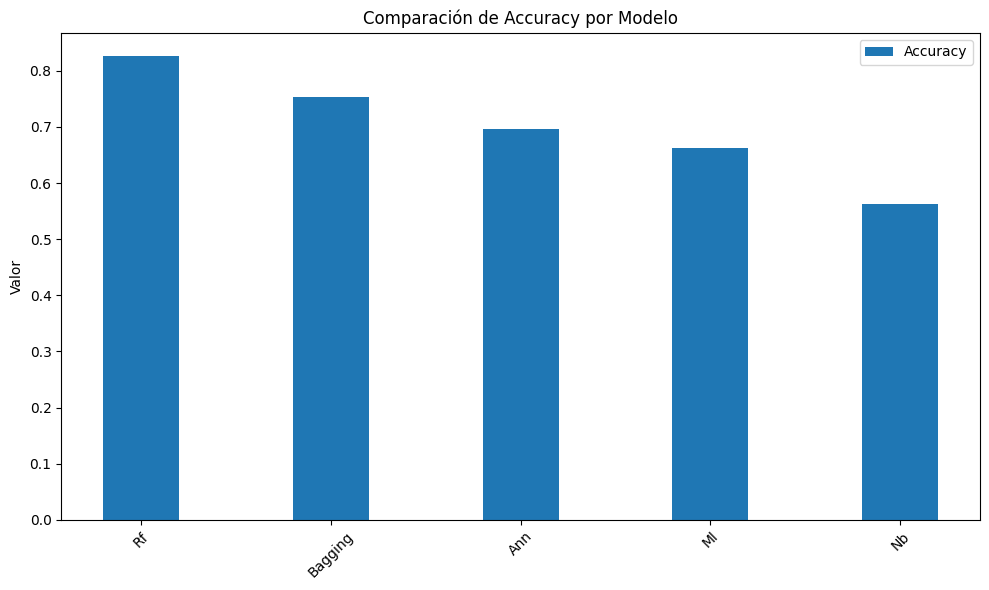

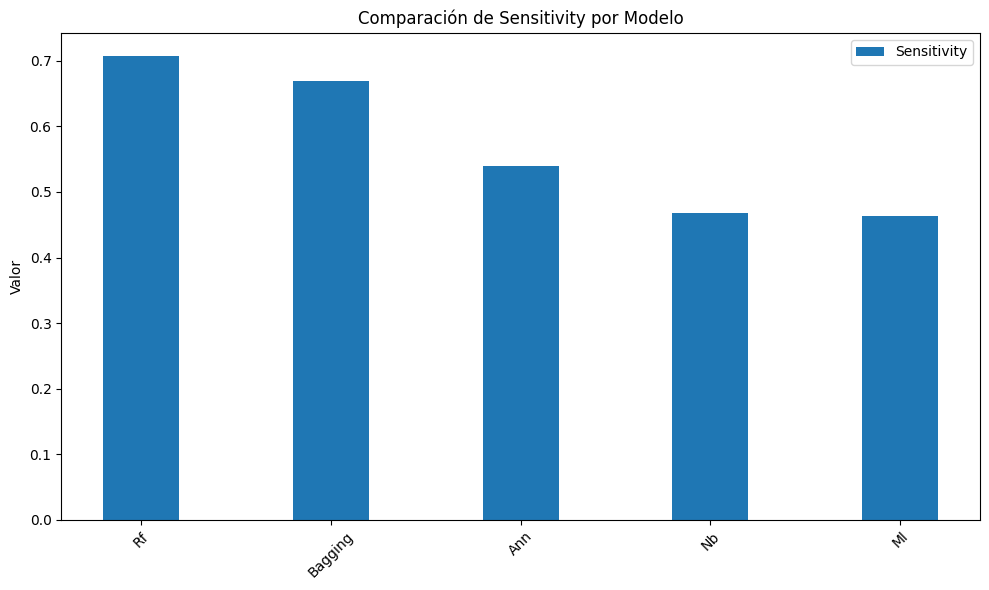

In [ ]:
# Defino la función para generar y mostrar el gráfico de barras
def plot_bar_chart(values, ylabel, title, label):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(len(sorted_model_names))

    plt.bar(x, values, width=0.4, align='center', label=label)

    plt.xticks(x, [model.replace('resultados_', '').replace('_',' ').capitalize() for model in sorted_model_names], rotation=45)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Defino las listas para almacenar valores de Accuracy y Sensitivity
accuracy_values = []
sensitivity_values = []

# Obtengo los valores de Accuracy y Sensitivity para cada modelo
for model in model_names:
    accuracy = globals()[f'{model}_accuracy']
    sensitivity = globals()[f'{model}_sensitivity']
    accuracy_values.append(accuracy)
    sensitivity_values.append(sensitivity)

# Creo una lista de tuplas (modelo, rendimiento) y la ordeno por rendimiento
model_performance = list(zip(model_names, accuracy_values))
model_performance.sort(key=lambda x: x[1], reverse=True)

# Separo los nombres de modelos ordenados y los valores de rendimiento
sorted_model_names = [model[0] for model in model_performance]
sorted_accuracy_values = [model[1] for model in model_performance]

# Llamo a la función para mostrar el gráfico de accuracy
plot_bar_chart(sorted_accuracy_values, 'Valor', 'Comparación de Accuracy por Modelo', 'Accuracy')

# Creo una lista de tuplas (modelo, rendimiento) y la ordeno por rendimiento
model_performance = list(zip(model_names, sensitivity_values))
model_performance.sort(key=lambda x: x[1], reverse=True)

# Separo los nombres de modelos ordenados y los valores de rendimiento
sorted_model_names = [model[0] for model in model_performance]
sorted_sensitivity_values = [model[1] for model in model_performance]

# Llamo a la función para mostrar el gráfico de sensitivity
plot_bar_chart(sorted_sensitivity_values, 'Valor', 'Comparación de Sensitivity por Modelo', 'Sensitivity')

Como podemos observar el modelo Random Forest es el que mejor desempeño tiene y por ello es el modelo que mejor predice el modelo de transporte escogido.